In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
demand = pd.read_csv('demand_train.csv')
stock = pd.read_csv('stock_train.csv')
sample_submission = pd.read_csv("提交结果模板.csv")

In [23]:
demand_cols_mapping = {
    '过账日期':'date',
    '需求量':'demand_amount',
    '工厂编码':'factory_code',
    '物料编码':'material_code',
    '物料品牌':'material_brand',
    '物料类型':'material_type',
    '物料品类':'material_category'
}
stock_cols_mapping = {
    '过账日期':'date',
    '库存量':'storage_amount',
    '工厂编码':'factory_code',
    '物料编码':'material_code',
    '物料品牌':'material_brand',
    '物料类型':'material_type',
    '物料品类':'material_category'
}

In [54]:
demand = demand.rename(columns = demand_cols_mapping)
stock = stock.rename(columns = stock_cols_mapping)
demand['date'] = pd.to_datetime(demand['date'])
stock['date'] = pd.to_datetime(stock['date'])

In [55]:
demand.head()

,date,demand_amount,factory_code,material_code,material_brand,material_type,material_category
0,2018-01-06,0.33,2004,1000,5000,3002,4014
1,2018-01-08,0.09,2010,1000,5000,3002,4014
2,2018-01-09,0.09,2008,1000,5000,3002,4014
3,2018-01-10,0.10,2010,1000,5000,3002,4014
4,2018-01-11,0.17,2004,1000,5000,3002,4014


In [56]:
stock.head()

,date,factory_code,material_code,material_brand,material_type,material_category,storage_amount
0,2018-01-24,2000,1001,5000,3002,4006,2.71
1,2018-01-24,2000,1003,5000,3002,4005,6.84
2,2018-01-24,2000,1014,5000,3002,4008,1.28
3,2018-01-24,2000,1021,5000,3002,4006,1.04
4,2018-01-24,2000,1027,5001,3002,4014,2.63


In [57]:
demand_df = demand.groupby(['date','factory_code','material_code'],as_index = False)['demand_amount'].sum()

In [58]:
stock_df = stock.groupby(['date','factory_code','material_code'],as_index = False)['storage_amount'].sum()

In [59]:
demand_df.head()

,date,factory_code,material_code,demand_amount
0,2018-01-01,2001,1029,1.29
1,2018-01-01,2001,1051,0.09
2,2018-01-01,2001,1054,0.70
3,2018-01-01,2001,1159,1.24
4,2018-01-01,2001,1167,6.40


In [60]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248503 entries, 0 to 248502
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           248503 non-null  datetime64[ns]
 1   factory_code   248503 non-null  int64         
 2   material_code  248503 non-null  int64         
 3   demand_amount  248503 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 9.5 MB


## EDA

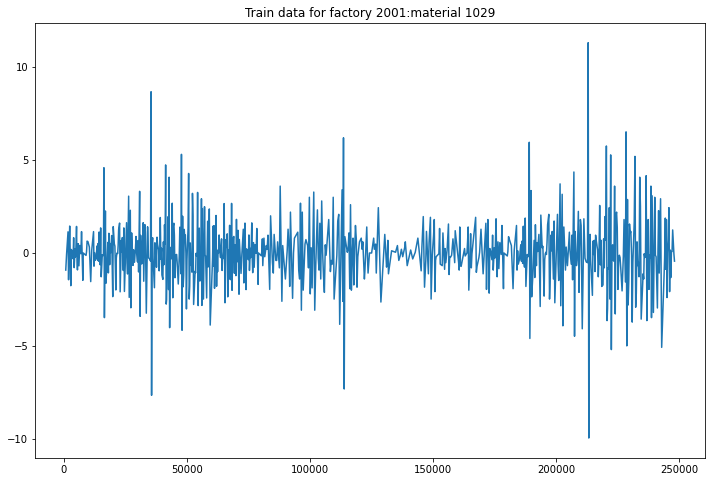

In [61]:
# Look at the data
plt.figure(figsize=(12, 8))
plt.plot(demand_df[(demand_df.factory_code == 2001) & (demand_df.material_code == 1029)]['demand_amount'].diff())
plt.title("Train data for factory 2001:material 1029")
plt.show()

In [62]:
demand_df.date.min(),demand_df.date.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-11-24 00:00:00'))

In [63]:
train = demand_df[demand_df.date < '2020-08-24']
test = demand_df[demand_df.date >= '2020-08-24']

In [64]:
model_delta = max(test.date) - max(train.date)
model_delta

Timedelta('93 days 00:00:00')

## Feature engineering

In [43]:
def get_date_features(df):
    
    # Add date-specific features
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.dayofweek // 5
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.weekofyear

    return df

In [ ]:
def generate_features(train, test):

    # Get the time delta between last test and last train observations
    model_delta = max(test.index) - max(train.index)

    # Initialize variables
    lags = [model_delta.days]
    window = 7
    lag_features = []

    # Concatenate train and test together
    data = pd.concat([train, test], sort=False)

    for lag in lags:
        feat = data.groupby(["factory_code", "material_code"])[["demand_amount"]].rolling(window=window).mean().shift(lag)
        feat.columns = ['demand_mean_lag_{}'.format(lag)]
        lag_features.append(feat)

        feat = data.groupby(["factory_code", "material_code"])[["demand_amount"]].rolling(window=window).std().shift(lag)
        feat.columns = ['demand_std_lag_{}'.format(lag)]
        lag_features.append(feat)

    # Concatenate all features together
    lag_features = pd.concat(lag_features, axis=1)

    # Add date features to the train and test
    train = get_date_features(train)
    test = get_date_features(test)

    # Join lag features to the train and test by (store, item, date)
    train.set_index(["factory_code", "material_code"], append=True, inplace=True)
    train = train.reorder_levels(["factory_code", "material_code", "date"])
    test.set_index(["factory_code", "material_code"], append=True, inplace=True)
    test = test.reorder_levels(["factory_code", "material_code", "date"])

    train = train.join(lag_features)
    test = test.join(lag_features)

    # Resetting index back
    train.reset_index(level=[0, 1], inplace=True)
    test.reset_index(level=[0, 1], inplace=True)
    
    return train, test, model_delta, window